#### Data science: Direct marketing optimization
##### Task:
Use dummy data to maximize revenue from direct marketing campaigns.
##### Data:                   
For the analysis, several tables are available:                  
1) Social-demographical data (age, gender, tenure in a bank)                 
2) Products owned + actual volumes (current account, saving account, mutual funds, overdraft, credit card, consumer loan)      
3) Inflow/outflow on C/A, aggregated card turnover (monthly average over past 3 months)          
4) For 60 % of clients actual sales + revenues from these are available (training set)                          

##### Conditions:     
> The bank has capacity to contact only 15 pct. of the clients (cca 100 people) with a marketing offer and each client can be targeted only once.Proposed steps:      
1. Create an analytical dataset (both training and targeting sets)                  
2. Develop 3 propensity models (consumer loan, credit card, mutual fund) using training data set                
3. Optimize targeting clients with the direct marketing offer to maximize the revenue 

##### Expected result:                                            
1) Which clients have higher propensity to buy consumer loan?             
2) Which clients have higher propensity to buy credit card?            
3) Which clients have higher propensity to buy mutual fund?              
4) Which clients are to be targeted with which offer? General description.            
5) What would be the expected revenue based on your strategy?             
##### The executive summary of the analysis should not be larger than two pages. Attach the technical report, list of clients to be contacted with which offer, data, algorithms and codes used.

In [375]:
# importing required packages
import pandas as pd
import numpy as np 
from collections import Counter
from sklearn.impute import KNNImputer
import math
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import arange
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,RandomForestRegressor,AdaBoostRegressor
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,roc_curve
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,confusion_matrix,roc_auc_score,f1_score, precision_recall_curve,auc
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import eli5

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

##### Reading Data Set

In [302]:
# reading the data set
df_demog = pd.read_excel("Task_Data_Scientist_Dataset.xlsx",engine='openpyxl',sheet_name='Soc_Dem')
df_prod = pd.read_excel("Task_Data_Scientist_Dataset.xlsx",engine='openpyxl',sheet_name='Products_ActBalance')
df_in_out = pd.read_excel("Task_Data_Scientist_Dataset.xlsx",engine='openpyxl',sheet_name='Inflow_Outflow')
df_sales = pd.read_excel("Task_Data_Scientist_Dataset.xlsx",engine='openpyxl',sheet_name='Sales_Revenues')

In [303]:
df_demog.head(3)

,Client,Sex,Age,Tenure
0,909,M,21,27
1,1217,M,38,165
2,850,F,49,44


In [304]:
df_prod.head(3)

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,NaN,NaN,1.0,NaN,NaN,1333.802857,NaN,NaN,0.0,NaN,NaN
1,2,1,1.0,NaN,NaN,NaN,NaN,110.768571,13326.190357,NaN,NaN,NaN,NaN
2,3,1,NaN,1.0,NaN,NaN,NaN,482.654643,NaN,107.251786,NaN,NaN,NaN


In [305]:
df_in_out.head(3)

,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1017,0.005000,0.005000,1,1,118.046429,118.046429,25.000000,91.796429,0.000000,12,12,2,9,0
1,1456,364.772143,364.752857,4,3,774.980000,774.980000,14.285714,497.444286,258.607143,28,28,1,20,5
2,545,2471.719286,2471.719286,14,14,2190.257143,2190.257143,303.571429,179.082143,1229.428571,23,23,3,5,12


In [306]:
df_sales.head(3)

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1094,0,1,0,0.000000,5.138571,0.0000
1,1484,1,0,1,25.609107,0.000000,8.7225
2,20,0,1,0,0.000000,3.822500,0.0000


##### Data Exploration

In [307]:
# printing shape of provided data set
print("Print shape of Social Demographic data set: ",df_demog.shape)
print("Print shape of Products Owned and their actual volumes data set: ",df_prod.shape)
print("print shape of Inflow and Outflow data set: ",df_in_out.shape)
print("print shape of Train set data set: ",df_sales.shape)

Print shape of Social Demographic data set:  (1615, 4)
Print shape of Products Owned and their actual volumes data set:  (1615, 13)
print shape of Inflow and Outflow data set:  (1587, 15)
print shape of Train set data set:  (969, 7)


we can see that their are 28 clients not present in Inflow and Outflow data set. Before merging these data set we have to drop those clients from Social Demographic and Products Owned data set.

In [308]:
# merging that two data set having same shape
df = pd.merge(df_demog, df_prod, how="left", on=["Client"])
df = pd.merge(df, df_in_out, how="left", on=["Client"])

In [309]:
print("Print shape of combined data set: ",df.shape)

Print shape of combined data set:  (1615, 30)


##### Spliting the data set into Train and Test

In [422]:
df_train = pd.merge(df, df_sales[['Client','Sale_CL','Revenue_CL']], how="inner", on=["Client"])

In [311]:
print("Print shape of combined data set: ",df_train.shape)

Print shape of combined data set:  (969, 32)


In [312]:
df_train.head(3)

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_CL,Revenue_CL
0,1217,M,38,165,1,NaN,NaN,NaN,NaN,NaN,6752.244643,NaN,NaN,NaN,NaN,NaN,0.002143,0.002143,1.0,1.0,714.285714,714.285714,0.000000,0.0000,714.285714,1.0,1.0,0.0,0.0,1.0,0,0.0
1,850,F,49,44,1,NaN,NaN,NaN,NaN,NaN,43.523214,NaN,NaN,NaN,NaN,NaN,1392.402857,1392.402857,3.0,3.0,1226.345357,1226.345357,0.000000,0.0000,121.928571,6.0,6.0,0.0,0.0,1.0,0,0.0
2,1473,M,54,34,1,1.0,NaN,NaN,1.0,1.0,29.024286,14447.801429,NaN,NaN,653.91,1132.590357,1787.127500,939.128929,14.0,5.0,3875.137857,3794.580714,357.142857,444.5975,2076.785714,48.0,38.0,1.0,26.0,11.0,0,0.0


we can see that most of columns are having very big range and few are having small values so before applying our models to the data set we have to do the scaling of the data set.

##### Data Pre-Processing

In [423]:
# columns which are not required for sale of Consumer loan prediction
# columns_sale_cl = ['Count_MF','Count_CC','ActBal_MF','ActBal_CC']
columns_sale_cl = ['Count_CL','ActBal_CL']
df_train.drop(columns_sale_cl,inplace = True,axis = 1)

In [314]:
# finding total number of duplicate values in data set if any
print('Total number of duplicate values in the data set is/are: {}'.format(df_train.duplicated().sum()))

Total number of duplicate values in the data set is/are: 0


There are no duplicate rows in the data set

In [424]:
# checking types of the columns in the data set
df_train.dtypes

Client                            int64
Sex                              object
Age                               int64
Tenure                            int64
Count_CA                          int64
Count_SA                        float64
Count_MF                        float64
Count_OVD                       float64
Count_CC                        float64
ActBal_CA                       float64
ActBal_SA                       float64
ActBal_MF                       float64
ActBal_OVD                      float64
ActBal_CC                       float64
VolumeCred                      float64
VolumeCred_CA                   float64
TransactionsCred                float64
TransactionsCred_CA             float64
VolumeDeb                       float64
VolumeDeb_CA                    float64
VolumeDebCash_Card              float64
VolumeDebCashless_Card          float64
VolumeDeb_PaymentOrder          float64
TransactionsDeb                 float64
TransactionsDeb_CA              float64


In [425]:
# replacing nan values of Sex field with U- Unknown
# df_train.dropna(subset = ["Sex"], inplace=True)

df_train.Sex = df_train.Sex.replace(np.nan,"U",regex=True)

In [426]:
# We have to convert Sex from object to numeric type
# df_train.Sex.unique()

# converting M and F to 1 and 0
df_train.Sex = df_train.Sex.replace({'M':1, 'F':0,'U':2})

In [427]:
# checking for null values in the data set
col = df_train.columns
for i in col:
    # count number of rows with missing values
    n_miss = df_train[[i]].isnull().sum()
    perc = n_miss / df_train.shape[0] * 100
    print('%s, Missing: %d (%.1f%%)' % (i, n_miss, perc))

Client, Missing: 0 (0.0%)
Sex, Missing: 0 (0.0%)
Age, Missing: 0 (0.0%)
Tenure, Missing: 0 (0.0%)
Count_CA, Missing: 0 (0.0%)
Count_SA, Missing: 704 (72.7%)
Count_MF, Missing: 785 (81.0%)
Count_OVD, Missing: 718 (74.1%)
Count_CC, Missing: 859 (88.6%)
ActBal_CA, Missing: 0 (0.0%)
ActBal_SA, Missing: 704 (72.7%)
ActBal_MF, Missing: 785 (81.0%)
ActBal_OVD, Missing: 718 (74.1%)
ActBal_CC, Missing: 859 (88.6%)
VolumeCred, Missing: 18 (1.9%)
VolumeCred_CA, Missing: 18 (1.9%)
TransactionsCred, Missing: 18 (1.9%)
TransactionsCred_CA, Missing: 18 (1.9%)
VolumeDeb, Missing: 18 (1.9%)
VolumeDeb_CA, Missing: 18 (1.9%)
VolumeDebCash_Card, Missing: 18 (1.9%)
VolumeDebCashless_Card, Missing: 18 (1.9%)
VolumeDeb_PaymentOrder, Missing: 18 (1.9%)
TransactionsDeb, Missing: 18 (1.9%)
TransactionsDeb_CA, Missing: 18 (1.9%)
TransactionsDebCash_Card, Missing: 18 (1.9%)
TransactionsDebCashless_Card, Missing: 18 (1.9%)
TransactionsDeb_PaymentOrder, Missing: 18 (1.9%)
Sale_CL, Missing: 0 (0.0%)
Revenue_CL, Miss

We can see that their are lot of missing values in the data set. Before applying any algorithm we have to either impute the values or drop the values.    
1) For sex we have two rows missing so I will impute it with U (Unknown) considering that client might not want to reveal their gender.   
2) For features from Inflow Outflow data set, having 18 rows missing in all of the feature we will impute it with 0 considering that client is in active in past 3 months.        
3) For feature from Product Owned data set we have almost 70-90% data set missing in all features. I think the feature might add value to our model so I will impute this also with 0 considering that client don't avail these features from the bank.    

We are not using mean or median imputation because it ignores the feature correlation and will also reduce the variance. Since the data set is very small, smaller variance leads to the narrower confidence interval in the probability distribution. This will lead to bias to our model.    

In [18]:
# imputing with KNNImputer
# col_mean = ['VolumeCred','VolumeCred_CA','TransactionsCred','TransactionsCred_CA','VolumeDeb','VolumeDeb_CA',
#            'VolumeDebCash_Card','VolumeDebCashless_Card','VolumeDeb_PaymentOrder','TransactionsDeb','TransactionsDeb_CA'
#            ,'TransactionsDebCash_Card','TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder']
# k = math.sqrt(df_train.shape[0])
# imputer = KNNImputer(n_neighbors=100, weights='uniform', metric='nan_euclidean')
# df_train = imputer.fit_transform(df_train)

In [19]:
# # deviding the data set into target and predictors
# X = df_train.copy()
# X.drop(['Client','Sale_CL'],inplace = True, axis = 1)
# y = df_train.iloc[:,30].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [319]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Client,969.0,814.781218,464.568139,1.000000,422.000000,819.000000,1216.000000,1615.000000
Sex,969.0,0.535604,0.503112,0.000000,0.000000,1.000000,1.000000,2.000000
Age,969.0,42.983488,18.578951,0.000000,29.000000,41.000000,57.000000,90.000000
Tenure,969.0,100.393189,65.437097,0.000000,42.000000,95.000000,151.000000,271.000000
Count_CA,969.0,1.075335,0.323815,1.000000,1.000000,1.000000,1.000000,4.000000
Count_SA,265.0,1.181132,0.457702,1.000000,1.000000,1.000000,1.000000,3.000000
Count_OVD,251.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Count_CL,79.0,1.113924,0.319749,1.000000,1.000000,1.000000,1.000000,2.000000
ActBal_CA,969.0,2493.026329,6268.027982,0.000000,73.135000,536.951429,2262.178929,74934.956071
ActBal_SA,265.0,14427.773550,32615.370810,0.000000,725.631429,4352.067857,13326.190357,389883.830714


we can see that minimum value for age is zero that means age column is having some erroneous values, we have to analyse age column and see how we can either impute values or if can't impute than drop the rows.

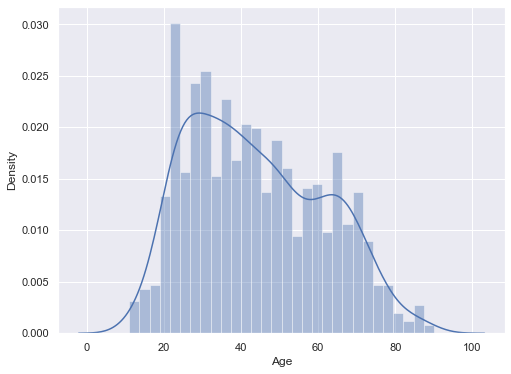

In [502]:
# density plot with tenure of customer with bank
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,6)})
sns.distplot(df_train.Age, bins=30);

In [320]:
# Checking age of customer where age is less than the tenure with the bank
df_train.query('Age*12 <=Tenure')

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_OVD,Count_CL,ActBal_CA,ActBal_SA,ActBal_OVD,ActBal_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_CL,Revenue_CL
4,225,1,14,187,1,NaN,1.0,NaN,345.686071,NaN,618.397500,NaN,0.007500,0.007500,1.0,1.0,130.521429,130.521429,0.000000,111.235714,19.285714,5.0,5.0,0.0,4.0,1.0,1,8.130714
6,1231,0,6,232,1,NaN,NaN,NaN,819.853929,NaN,NaN,NaN,0.015714,0.015714,2.0,2.0,2257.000000,2257.000000,2250.000000,0.000000,0.000000,9.0,9.0,6.0,0.0,0.0,1,24.434643
11,316,0,1,211,1,NaN,NaN,NaN,22.733571,NaN,NaN,NaN,1022.846071,1022.846071,6.0,6.0,1026.817857,1026.817857,535.714286,7.710714,481.464286,21.0,21.0,6.0,1.0,9.0,1,15.015357
16,1160,1,19,260,1,NaN,1.0,1.0,2723.980357,NaN,0.000000,4239.877500,884.592857,865.297143,3.0,2.0,929.517857,925.625000,285.714286,190.814286,178.642857,28.0,26.0,3.0,9.0,7.0,1,17.993214
24,682,0,3,149,1,1.0,NaN,NaN,684.281429,4557.607500,NaN,NaN,1152.682857,866.500714,5.0,3.0,1043.535714,1043.535714,742.857143,0.000000,297.928571,22.0,22.0,12.0,0.0,2.0,1,9.392857
100,322,0,1,92,1,1.0,NaN,NaN,2175.270000,128617.591071,NaN,NaN,28.572500,28.572500,2.0,2.0,919.821429,919.821429,0.000000,0.000000,0.000000,2.0,2.0,0.0,0.0,0.0,0,0.000000
124,1499,0,5,267,1,NaN,1.0,1.0,0.000000,NaN,127.357143,12738.255357,1376.794643,1339.050357,5.0,4.0,1733.850714,1730.886429,285.714286,344.922143,395.857143,31.0,30.0,4.0,10.0,12.0,1,7.107143
138,1561,1,12,204,1,1.0,NaN,NaN,361.470357,1927.531786,NaN,NaN,1250.163571,1142.859643,6.0,4.0,1964.546786,1285.975357,246.428571,670.128929,104.750000,21.0,19.0,2.0,12.0,1.0,1,4.214286
143,638,1,1,31,1,NaN,1.0,NaN,89.250000,NaN,0.000000,NaN,592.828214,592.828214,2.0,2.0,885.978571,885.978571,535.714286,140.728571,23.642857,9.0,9.0,1.0,4.0,1.0,0,0.000000
203,1431,0,19,231,1,NaN,NaN,NaN,1046.317143,NaN,NaN,NaN,714.295357,714.295357,2.0,2.0,668.489286,668.489286,0.000000,0.000000,535.714286,5.0,5.0,0.0,0.0,1.0,1,16.476429


We can see that their are 34 rows where age less than the tenure with the bank so we assume that either data in age or tenure is incorrect. But after carefuly considering both the columns we can see that in some case age is even less than 10 years and the client is holding a current account with the bank. So we can say that values in age is wrong.    

##### Assumption     
1) we assume that to have a bank account with bank client must be atleast of 10 years. Since, even to have a student account the student must be atleast 10 years.      
2) To impute the age we will add 10 years with tenure of the client.

In [428]:
# imputing age with tenure + 120 months 
df_train.Age = np.where((df_train.Age *12 <= df_train.Tenure),round(df_train.Tenure/12) + 10,df_train.Age)

In [429]:
# imputing other values with 0 in the data set
df_train.fillna(0,inplace = True)

In [21]:
# # imputing with KNNImputer
# # col_mean = ['VolumeCred','VolumeCred_CA','TransactionsCred','TransactionsCred_CA','VolumeDeb','VolumeDeb_CA',
# #            'VolumeDebCash_Card','VolumeDebCashless_Card','VolumeDeb_PaymentOrder','TransactionsDeb','TransactionsDeb_CA'
# #            ,'TransactionsDebCash_Card','TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder']
# k = math.sqrt(df_train.shape[0])
# imputer = KNNImputer(n_neighbors=round(k), weights='uniform', metric='nan_euclidean')
# df_train[col] = imputer.fit_transform(df_train.values)

In [430]:
df_train.isnull().sum()

Client                          0
Sex                             0
Age                             0
Tenure                          0
Count_CA                        0
Count_SA                        0
Count_MF                        0
Count_OVD                       0
Count_CC                        0
ActBal_CA                       0
ActBal_SA                       0
ActBal_MF                       0
ActBal_OVD                      0
ActBal_CC                       0
VolumeCred                      0
VolumeCred_CA                   0
TransactionsCred                0
TransactionsCred_CA             0
VolumeDeb                       0
VolumeDeb_CA                    0
VolumeDebCash_Card              0
VolumeDebCashless_Card          0
VolumeDeb_PaymentOrder          0
TransactionsDeb                 0
TransactionsDeb_CA              0
TransactionsDebCash_Card        0
TransactionsDebCashless_Card    0
TransactionsDeb_PaymentOrder    0
Sale_CL                         0
Revenue_CL    

In [324]:
# statistical analysis of the data set
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Client,969.0,814.781218,464.568139,1.0,422.000000,819.000000,1216.000000,1615.000000
Sex,969.0,0.535604,0.503112,0.0,0.000000,1.000000,1.000000,2.000000
Age,969.0,43.552116,17.683560,2.0,29.000000,41.000000,57.000000,90.000000
Tenure,969.0,100.393189,65.437097,0.0,42.000000,95.000000,151.000000,271.000000
Count_CA,969.0,1.075335,0.323815,1.0,1.000000,1.000000,1.000000,4.000000
Count_SA,969.0,0.323013,0.578450,0.0,0.000000,0.000000,1.000000,3.000000
Count_OVD,969.0,0.259030,0.438328,0.0,0.000000,0.000000,1.000000,1.000000
Count_CL,969.0,0.090815,0.318195,0.0,0.000000,0.000000,0.000000,2.000000
ActBal_CA,969.0,2493.026329,6268.027982,0.0,73.135000,536.951429,2262.178929,74934.956071
ActBal_SA,969.0,3945.675945,18207.655212,0.0,0.000000,0.000000,0.395714,389883.830714


Still we can see some clients having age less than 10 years so now we will impute these with KNNImputer considering these vales are missing at random.    

In [431]:
# imputing with KNNImputer
k = math.sqrt(df_train.shape[0])
imputer = KNNImputer(n_neighbors=round(k), weights='uniform', metric='nan_euclidean')
# df_train.Age = df_train.Age.replace('Age<=10',np.nan,regex=True)
df_train.Age = df_train.Age.mask(df_train.Age <= 10)
df_train[col] = imputer.fit_transform(df_train.values)
# df_train.Age = np.where((df_train.Age *12 <= df_train.Tenure),imputer.fit_transform(df_train.Age.value),df_train.Age)

In [ ]:
# sns.pairplot(df_train[col], hue='Sale_CL', corner=True);

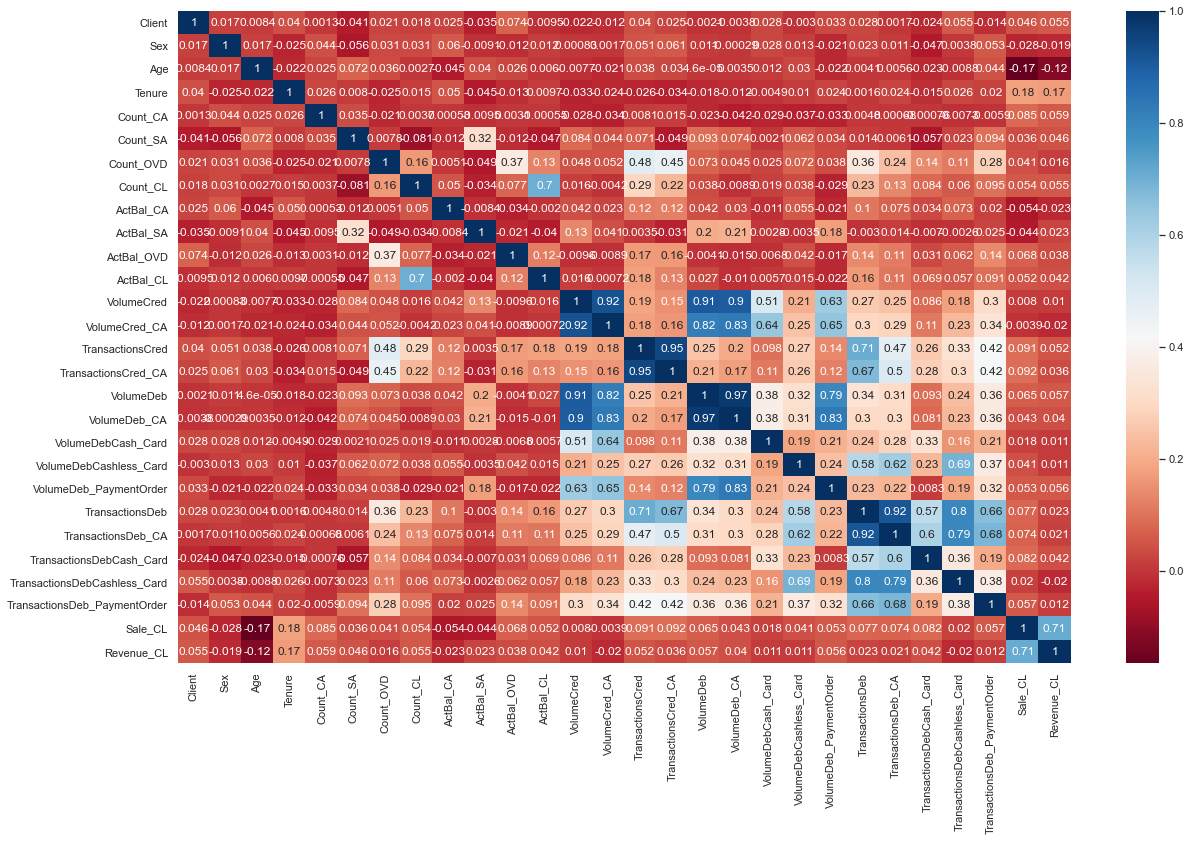

In [327]:
# Checking for multicollinearity

plt.figure(figsize=(20,12))
sns.heatmap(df_train.corr(),cmap='RdBu',annot=True);

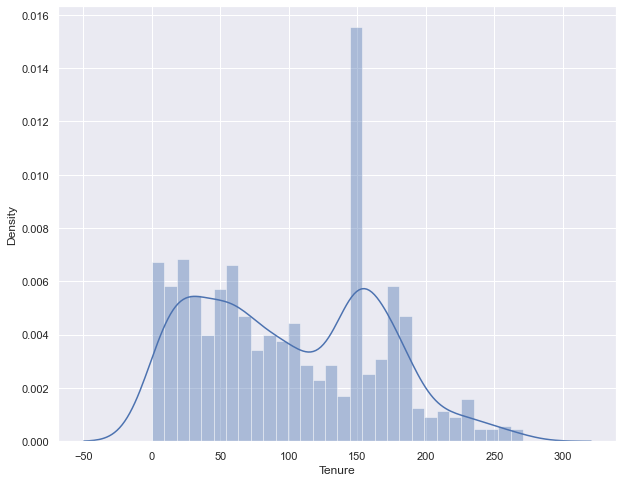

In [501]:
# density plot with tenure of customer with bank
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,8)})
sns.distplot(df_train.Tenure, bins=30);

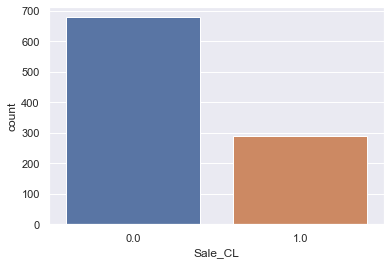

In [329]:
sns.set(rc={'figure.figsize':(6,4)})
sns.countplot(df_train.Sale_CL);

Their is clear imbalance in the data set we have to handle this also while applying our machine learning algorithm.
Two ways by which we can handle this class imbalance problem:    
1) By adjusting the class weight while training    
2) By over/under sampling of the data set    

In [436]:
#Splitting data set into train and test
# deviding the data set into target and predictors
X = df_train.copy()
X.drop(['Client','Sale_CL','Revenue_CL'],inplace = True, axis = 1)
y_sale_cl = df_train.iloc[:,28].values
y_revenue_cl = df_train.iloc[:,29].values
X_train, X_test, y_train, y_test = train_test_split(X, y_sale_cl, test_size=0.2, stratify=y_sale_cl, random_state=1)


##### Machine learning Models

Applying ML classification models for predicting sale of consumer loan

In [437]:
def model_evaluation(model,scale = False, classification = False):
    if classification == True:
        scoring = [    'precision', 
                       'recall',
                       'f1', 
                       'accuracy']
    else:
        scoring = [    
                       'neg_mean_squared_error',
                       'neg_mean_absolute_error',
                       'neg_root_mean_squared_error'
                       ]
    # Declaring parameters
    R_STATE = 1
    over = RandomOverSampler(sampling_strategy=0.3,random_state = 1)
    under = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
    if scale == True :
        Steps = [
        #             ('i', KNNImputer(n_neighbors=31)),
    #                 ('ov',over),
    #                 ('un',under),
                    ('minmaxscaler',MinMaxScaler(feature_range=(0, 1))),
                    ('m', model)
                ]
    else:
        Steps = [
            #             ('i', KNNImputer(n_neighbors=31)),
        #                 ('ov',over),
        #                 ('un',under),
                        ('m', model)
                    ]
    pipeline = Pipeline(steps=Steps)
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    if classification == True:
        scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
        # store results
        score_df = pd.DataFrame(scores)
    else:
        scores = cross_validate(pipeline, X_train_reg, y_train_reg, scoring=scoring, cv=10, n_jobs=-1)
        # store results
        score_df = pd.DataFrame(scores)
    return score_df

In [340]:
# print("Model Evaluation for Ada Boost Algorithm")
# model_evaluation(AdaBoostClassifier(),scale = False,classification=True)

In [438]:
print("Model Evaluation XGBoost Algorithm")
model_evaluation(XGBClassifier(),scale = False,classification=True)

Model Evaluation XGBoost Algorithm


,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy
0,5.804512,0.046800,0.583333,0.304348,0.400000,0.729032
1,1.765433,0.046800,0.515152,0.369565,0.430380,0.709677
2,4.809089,0.044003,0.392857,0.239130,0.297297,0.664516
3,3.416053,0.053003,0.483871,0.319149,0.384615,0.690323
4,2.875263,0.103006,0.464286,0.276596,0.346667,0.683871
5,3.437071,0.046800,0.470588,0.347826,0.400000,0.690323
6,1.305432,0.078000,0.366667,0.239130,0.289474,0.651613
7,2.903459,0.031200,0.580645,0.391304,0.467532,0.735484
8,1.642236,0.031200,0.565217,0.276596,0.371429,0.716129
9,2.397451,0.031200,0.600000,0.319149,0.416667,0.729032


In [439]:
print("Model Evaluation Random Forest Classifier Algorithm")
model_evaluation(RandomForestClassifier(),scale = False,classification=True)

Model Evaluation Random Forest Classifier Algorithm


,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy
0,1.961082,0.131007,0.769231,0.217391,0.338983,0.748387
1,1.789072,0.128008,0.785714,0.239130,0.366667,0.754839
2,2.185090,0.140400,0.500000,0.152174,0.233333,0.703226
3,2.205889,0.156000,0.529412,0.191489,0.281250,0.703226
4,1.758221,0.128007,0.500000,0.106383,0.175439,0.696774
5,1.845226,0.131008,0.523810,0.239130,0.328358,0.709677
6,2.108646,0.109200,0.444444,0.086957,0.145455,0.696774
7,1.796839,0.140206,0.444444,0.173913,0.250000,0.690323
8,1.410632,0.093600,0.727273,0.170213,0.275862,0.729032
9,1.235618,0.093600,0.642857,0.191489,0.295082,0.722581


In [440]:
print("Model Evaluation Logistic Regression Algorithm")
model_evaluation(LogisticRegression(class_weight={0:0.3,1:0.7}),scale = True,classification=True)

Model Evaluation Logistic Regression Algorithm


,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy
0,0.128008,0.041601,0.439394,0.630435,0.517857,0.651613
1,0.119007,0.034601,0.428571,0.586957,0.495413,0.645161
2,0.099006,0.062400,0.405405,0.652174,0.500000,0.612903
3,0.098605,0.031200,0.391304,0.574468,0.465517,0.600000
4,0.109200,0.046800,0.360465,0.659574,0.466165,0.541935
5,0.093600,0.046800,0.404494,0.782609,0.533333,0.593548
6,0.062400,0.046800,0.357143,0.543478,0.431034,0.574194
7,0.078001,0.046800,0.343750,0.478261,0.400000,0.574194
8,0.062400,0.031200,0.592593,0.680851,0.633663,0.761290
9,0.062400,0.031200,0.415385,0.574468,0.482143,0.625806


In [466]:
print("Model Evaluation Naive Bayes Algorithm")
model_evaluation(MultinomialNB(),scale = True,classification=True)

Model Evaluation Naive Bayes Algorithm


,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy
0,0.026001,0.187011,1.000000,0.021739,0.042553,0.709677
1,0.114007,0.126007,1.000000,0.021739,0.042553,0.709677
2,0.026001,0.030002,0.000000,0.000000,0.000000,0.703226
3,0.047003,0.101006,0.250000,0.021277,0.039216,0.683871
4,0.046003,0.066004,0.000000,0.000000,0.000000,0.696774
5,0.078004,0.034200,0.500000,0.021739,0.041667,0.703226
6,0.032601,0.046800,0.666667,0.043478,0.081633,0.709677
7,0.038201,0.046800,0.000000,0.000000,0.000000,0.703226
8,0.046800,0.046800,1.000000,0.021277,0.041667,0.703226
9,0.031200,0.031200,0.000000,0.000000,0.000000,0.696774


After validating all the models we can see that AdaBoost and Logistic regression performed well with the given data set so we will perform hyperparameter tunning to see if we can improve the model performance

##### AdaBoost Classifier

In [442]:
# creating a parameter grid for cross validation and hyper parameter tuning

cv_abc = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
param_grid_abc = {'m__n_estimators':[70,100],
              'm__learning_rate':[1.0,0.8,0.5]
#               'm__class_weight':[{0:0.1,1:0.9},{0:0.20,1:0.80},'balanced']
#               'm__solver':['lbfgs','saga','liblinear']
              
}
model = AdaBoostClassifier()
Steps_abc = [('m', model)]
pipeline_abc = Pipeline(steps = Steps_abc)
grid_search_abc = GridSearchCV(estimator = pipeline_abc, param_grid = param_grid_abc, cv = cv_abc, n_jobs = -1, verbose = 2)

In [443]:
grid_search_abc.fit(X_train, y_train)
grid_search_abc.best_params_

Fitting 10 folds for each of 6 candidates, totalling 60 fits


{'m__learning_rate': 0.5, 'm__n_estimators': 70}

In [444]:
model_abc = grid_search_abc.best_estimator_

In [445]:
# predicting the values using X_test data set
y_pred_abc = model_abc.predict(X_test)

In [446]:
print(classification_report(y_test,y_pred_abc))

              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83       136
         1.0       0.65      0.19      0.29        58

    accuracy                           0.73       194
   macro avg       0.69      0.57      0.56       194
weighted avg       0.71      0.73      0.67       194



##### Logistic Regression Alogorithm

In [447]:
# creating grid for Logistic regression
cv_lr = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
param_grid_lr = {'m__max_iter':[40,70,100],
              'm__penalty':['l1','l2','elasticnet'],
              'm__class_weight':[{0:0.35,1:0.65},{0:0.30,1:0.70},'balanced']
#               'm__solver':['lbfgs','saga','liblinear']
                }
model = LogisticRegression()
Steps_lr = [
            ('msc',MinMaxScaler(feature_range=(0, 1))),
#             ('sc',StandardScaler()),
            ('m', model)
]
pipeline_lr = Pipeline(steps = Steps_lr)
grid_search_lr = GridSearchCV(estimator = pipeline_lr, param_grid = param_grid_lr, cv = cv_lr, n_jobs = -1, verbose = 2)                 

In [448]:
grid_search_lr.fit(X_train, y_train)
grid_search_lr.best_params_

Fitting 10 folds for each of 27 candidates, totalling 270 fits


{'m__class_weight': {0: 0.35, 1: 0.65}, 'm__max_iter': 40, 'm__penalty': 'l2'}

In [449]:
model_lr = grid_search_lr.best_estimator_

In [450]:
# predicting the values using X_test data set
y_pred_lr = model_lr.predict(X_test)

In [451]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.82       136
         1.0       0.59      0.41      0.48        58

    accuracy                           0.74       194
   macro avg       0.68      0.64      0.65       194
weighted avg       0.72      0.74      0.72       194



In [452]:
confusion_matrix(y_test,y_pred_lr)

array([[119,  17],
       [ 34,  24]], dtype=int64)

ROC AUC: 0.708


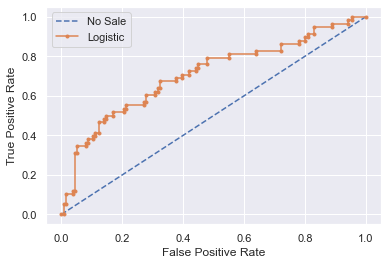

In [473]:
# ROC curve

# predict probabilities
yhat_roc = model_lr.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs_roc = yhat_roc[:, 1]
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Sale')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs_roc)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
roc_auc = roc_auc_score(y_test, pos_probs_roc)
print('ROC AUC: %.3f' % roc_auc)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

PR AUC: 0.520


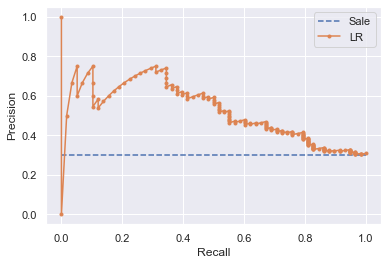

In [453]:
# Precision-Recall Curve

# predict probabilities
yhat = model_lr.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
sale = len(y_train[y_train==1]) / len(y_train)
plt.plot([0, 1], [sale, sale], linestyle='--', label='Sale')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='LR')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

Feature: Sex, Score: -0.28249
Feature: Age, Score: -1.21353
Feature: Tenure, Score: 1.12738
Feature: Count_CA, Score: 0.78924
Feature: Count_SA, Score: 0.18146
Feature: Count_MF, Score: 0.35756
Feature: Count_OVD, Score: 0.19403
Feature: Count_CC, Score: -0.22855
Feature: ActBal_CA, Score: -0.50453
Feature: ActBal_SA, Score: -0.46803
Feature: ActBal_MF, Score: 0.51478
Feature: ActBal_OVD, Score: 0.49712
Feature: ActBal_CC, Score: -0.67829
Feature: VolumeCred, Score: -0.16480
Feature: VolumeCred_CA, Score: -0.20770
Feature: TransactionsCred, Score: 0.51734
Feature: TransactionsCred_CA, Score: 0.48186
Feature: VolumeDeb, Score: 0.59297
Feature: VolumeDeb_CA, Score: 0.25493
Feature: VolumeDebCash_Card, Score: -0.05064
Feature: VolumeDebCashless_Card, Score: 0.22477
Feature: VolumeDeb_PaymentOrder, Score: 0.49908
Feature: TransactionsDeb, Score: 0.22240
Feature: TransactionsDeb_CA, Score: 0.14990
Feature: TransactionsDebCash_Card, Score: 0.45765
Feature: TransactionsDebCashless_Card, Score

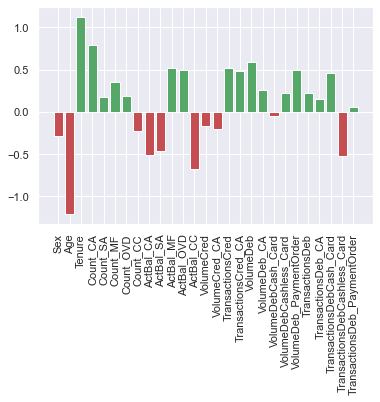

In [454]:
# feature importance code
    
importance = model_lr.named_steps['m'].coef_[0]
cols = list(X_train.columns)

# function to color the plot
def bar_color(df,color1,color2):
    return np.where(importance>0,color1,color2).T

# summarize feature importance
for col,score in zip(X_train.columns,importance):
    print('Feature: %0s, Score: %.5f' % (col,score))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance, color=bar_color(importance,'g','r'))
plt.xticks([x for x in range(len(importance))], cols, rotation=90)
plt.show()

We can see that for the given data set Logistic regression performed well when we changed the class weight. We will use this model for final prediction of sale of consumer loan.

##### Applying Machine Learning Model

Applying Machine Learning model for regression problem and to find the revenue from the sale of consumer loan

In [455]:
#Splitting data set into train and test
# deviding the data set into target and predictors for regression problem
X_reg = df_train.copy()
X_reg.drop(['Client','Revenue_CL'],inplace = True, axis = 1)
# y_sale_cl = df_train.iloc[:,26].values
y_revenue_cl = df_train.iloc[:,29].values
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_revenue_cl, test_size=0.2, random_state=1)


In [456]:
model_evaluation(RandomForestRegressor(),scale = False,classification = False)

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_neg_root_mean_squared_error
0,2.781077,0.073202,-12.361084,-1.338591,-3.515833
1,2.284066,0.078001,-21.338339,-2.113083,-4.619344
2,2.460666,0.098006,-25.393445,-2.300337,-5.039191
3,2.448868,0.101605,-10.475510,-1.208147,-3.236589
4,2.225636,0.093600,-14.330594,-1.866318,-3.785577
5,2.294428,0.078000,-24.525547,-1.776968,-4.952327
6,2.247628,0.078000,-13.023763,-1.473104,-3.608845
7,2.260224,0.062400,-6.984617,-1.182034,-2.642843
8,1.794003,0.082001,-18.576768,-2.014284,-4.310078
9,1.716206,0.046800,-13.177412,-1.733384,-3.630071


In [457]:
model_evaluation(AdaBoostRegressor(),scale = False,classification = False)

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_neg_root_mean_squared_error
0,1.111429,0.090005,-21.047713,-3.534861,-4.587779
1,0.961223,0.071202,-32.275871,-4.065605,-5.681186
2,0.989423,0.063004,-28.388435,-3.636422,-5.328080
3,0.936420,0.057003,-23.124903,-3.760424,-4.808836
4,1.068427,0.046800,-24.286076,-4.174343,-4.928090
5,0.555825,0.046800,-27.649503,-2.022280,-5.258280
6,0.990225,0.062400,-11.724504,-1.792258,-3.424106
7,1.023619,0.046800,-21.366803,-4.251730,-4.622424
8,0.811201,0.031200,-27.740175,-3.764571,-5.266894
9,0.625803,0.031200,-31.241558,-5.022214,-5.589415


In [458]:
# import sklearn as sklearn
# sklearn.metrics.SCORERS.keys()

From the cross validation results we can see that Linear regression and random forest is performing well so we will do hyper-parameter tunning for this two algorithm and try to improve the model performance.

In [460]:
from sklearn.linear_model import Ridge
model_evaluation(Ridge(),scale = True,classification = False)

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_neg_root_mean_squared_error
0,0.033002,0.0156,-13.150314,-1.735123,-3.626336
1,0.023001,0.0000,-23.606408,-2.511717,-4.858643
2,0.031200,0.0156,-17.360884,-2.025654,-4.166639
3,0.031200,0.0468,-7.730453,-1.268423,-2.780369
4,0.031200,0.0156,-15.781690,-2.028627,-3.972617
5,0.046800,0.0156,-26.266852,-2.195162,-5.125120
6,0.046800,0.0156,-9.718484,-1.721162,-3.117448
7,0.046800,0.0156,-7.762054,-1.440280,-2.786046
8,0.031200,0.0156,-17.500901,-2.225405,-4.183408
9,0.046800,0.0000,-10.889479,-1.748330,-3.299921


We can see that out of all models Random forest and Ridge performed well so we will do hyper-parameter tunning for improving the model performance.


##### Random Forest Regression

In [461]:
# creating a parameter grid for cross validation and hyper parameter tuning
param_grid_rf = {
    'm__max_depth': [80, 90],
    'm__min_samples_leaf': [ 4, 5],
    'm__min_samples_split': [8, 10],
    'm__n_estimators': [50,100,150]
}
model = RandomForestRegressor()
Steps_rf = [ ('m', model)]
pipeline_rf = Pipeline(steps = Steps_rf)
grid_search_rf = GridSearchCV(estimator = pipeline_rf, param_grid = param_grid_rf, cv = 10, n_jobs = -1, verbose = 2)  
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [462]:
grid_search_rf.fit(X_train_reg, y_train_reg)
grid_search_rf.best_params_

Fitting 10 folds for each of 24 candidates, totalling 240 fits


{'m__max_depth': 90,
 'm__min_samples_leaf': 5,
 'm__min_samples_split': 8,
 'm__n_estimators': 150}

In [463]:
model_rf = grid_search_rf.best_estimator_

In [464]:
# predicting the values using X_test data set
y_pred_rf = model_rf.predict(X_test_reg)

In [467]:
# Calculating the metrics for our model performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_reg, y_pred_rf))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_reg, y_pred_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_reg, y_pred_rf)))

Mean Absolute Error: 2.4229022528304363
Mean Squared Error: 95.16530308105926
Root Mean Squared Error: 9.755270528337965


In [475]:
# # Finding the important feature from the model
# importance = model_rf.feature_importances_
# cols_reg = X_train_reg.columns
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %s, Score: %.5f' % (cols_reg[i],v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

In [484]:
# Feature importance
cols_reg = list(X_train_reg.columns)
eli5.explain_weights(model_rf.named_steps['m'], top=15, feature_names=cols_reg)

Weight,Feature
0.7702 ± 0.0424,Sale_CL
0.0576 ± 0.0472,ActBal_CA
0.0213 ± 0.0338,Age
0.0174 ± 0.0295,Tenure
0.0143 ± 0.0321,VolumeDebCash_Card
0.0136 ± 0.0272,VolumeCred
0.0127 ± 0.0305,VolumeCred_CA
0.0118 ± 0.0280,TransactionsDeb_PaymentOrder
0.0106 ± 0.0246,VolumeDeb_PaymentOrder
0.0089 ± 0.0254,VolumeDeb_CA


##### Ridge Regression Algorithm

In [492]:
# creating a parameter grid for cross validation and hyper parameter tuning

param_grid_rd = {
    'm__alpha': arange(0, 1, 0.01)
    
}

model = Ridge()
Steps_rd = [ ('m', model)]
pipeline_rd = Pipeline(steps = Steps_rd)
grid_search_rd = GridSearchCV(estimator = pipeline_rd, param_grid = param_grid_rd, cv = 10, n_jobs = -1, verbose = 2)  
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [493]:
grid_search_rd.fit(X_train_reg, y_train_reg)
grid_search_rd.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


{'m__alpha': 0.99}

In [494]:
model_rd = grid_search_rd.best_estimator_

In [495]:
# predicting the values using X_test data set
y_pred_rd = model_rd.predict(X_test_reg)

In [496]:
# Calculating the metrics for our model performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_reg, y_pred_rd))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_reg, y_pred_rd))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_reg, y_pred_rd)))

Mean Absolute Error: 2.519552090705336
Mean Squared Error: 92.04793048292959
Root Mean Squared Error: 9.59416127042534


In [499]:
# Feature Importance

eli5.explain_weights(model_rd.named_steps['m'], top=15, feature_names=cols_reg)

Explanation(estimator='Ridge(alpha=0.99)', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='Sale_CL', weight=11.439248285726213, std=None, value=None), FeatureWeight(feature='Count_OVD', weight=0.3712241707746366, std=None, value=None), FeatureWeight(feature='TransactionsCred_CA', weight=0.1430592317293996, std=None, value=None), FeatureWeight(feature='Count_SA', weight=0.10214027094853033, std=None, value=None), FeatureWeight(feature='TransactionsDeb', weight=0.09329536954803637, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=0.019191649210901662, std=None, value=None), FeatureWeight(feature='Count_MF', weight=0.005108190134278097, std=None, value=None)], neg=[FeatureWeight(feature='Count_CC', weight=-0.4115693915848901, std=None, value=None), FeatureWeight(feature='Sex', weight=-0.2564408394901958, std=None, value=None), FeatureWeight(feature='TransactionsCred', weight=-0.20497937396075586, std=None, value=None), FeatureWeight(feature='Count_CA', weight=-0.13908000179955243, std=None, value=None), FeatureWeight(feature='TransactionsDeb_PaymentOrder', weight=-0.10032377297308707, std=None, value=None), FeatureWeight(feature='TransactionsDebCashless_Card', weight=-0.08549815260855682, std=None, value=None), FeatureWeight(feature='TransactionsDeb_CA', weight=-0.031234440339973687, std=None, value=None), FeatureWeight(feature='TransactionsDebCash_Card', weight=-0.015165298565881804, std=None, value=None)], pos_remaining=10, neg_remaining=4), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)